In this notebook, we will train machine learning models to predict precipitation given the local values of humidity and temperature. First, we must familiarize ourselves with the data by visualizing it along many dimensions. Then, we will discuss how to train a machine learning model.

The data comes from a very high resolution (4 km) fluid dynamics simulation of the atmosphere performed in a 10000km by 20000km domain. A single 3D field (e.g. temperature) is around 2 GB in size. For the purposes of this demonstration, I have resampled the data onto  (160 km)$^2$ grid boxes and taken only around 20 time points.

In [1]:
%matplotlib inline
import holoviews as hv
import xarray as xr
hv.extension('bokeh')

In [2]:
data_path = "2018-11-05-ngaqua-sam-subset-data.nc"

# Load the Data

In [4]:
ds = xr.open_dataset(data_path)
precip = ds.Prec
ds

<xarray.Dataset>
Dimensions:     (time: 16, x: 128, y: 64, z: 34)
Coordinates:
  * time        (time) float64 100.6 105.6 110.6 115.6 120.6 125.6 130.6 ...
  * x           (x) float32 0.0 160000.0 320000.0 480000.0 640000.0 800000.0 ...
  * y           (y) float32 0.0 160000.0 320000.0 480000.0 640000.0 800000.0 ...
  * z           (z) float32 37.0 112.0 194.0 288.0 395.0 520.0 667.0 843.0 ...
Data variables:
    FQT         (time, z, y, x) float64 ...
    FSLI        (time, z, y, x) float64 ...
    FU          (time, z, y, x) float64 ...
    FV          (time, z, y, x) float64 ...
    LHF         (time, y, x) float32 ...
    PP          (time, z, y, x) float32 ...
    Prec        (time, y, x) float32 ...
    QT          (time, z, y, x) float32 ...
    QV          (time, z, y, x) float32 ...
    RADSFC      (time, y, x) float32 ...
    RADTOA      (time, y, x) float32 ...
    SHF         (time, y, x) float32 ...
    SLI         (time, z, y, x) float32 ...
    SOLIN       (time, y, x) f

# Visualizing the data

**Objectives**:

1. Use `xarray` `.plot` methods to visualize a high dimensional dataset
2. Use `holoviews` to do the same.

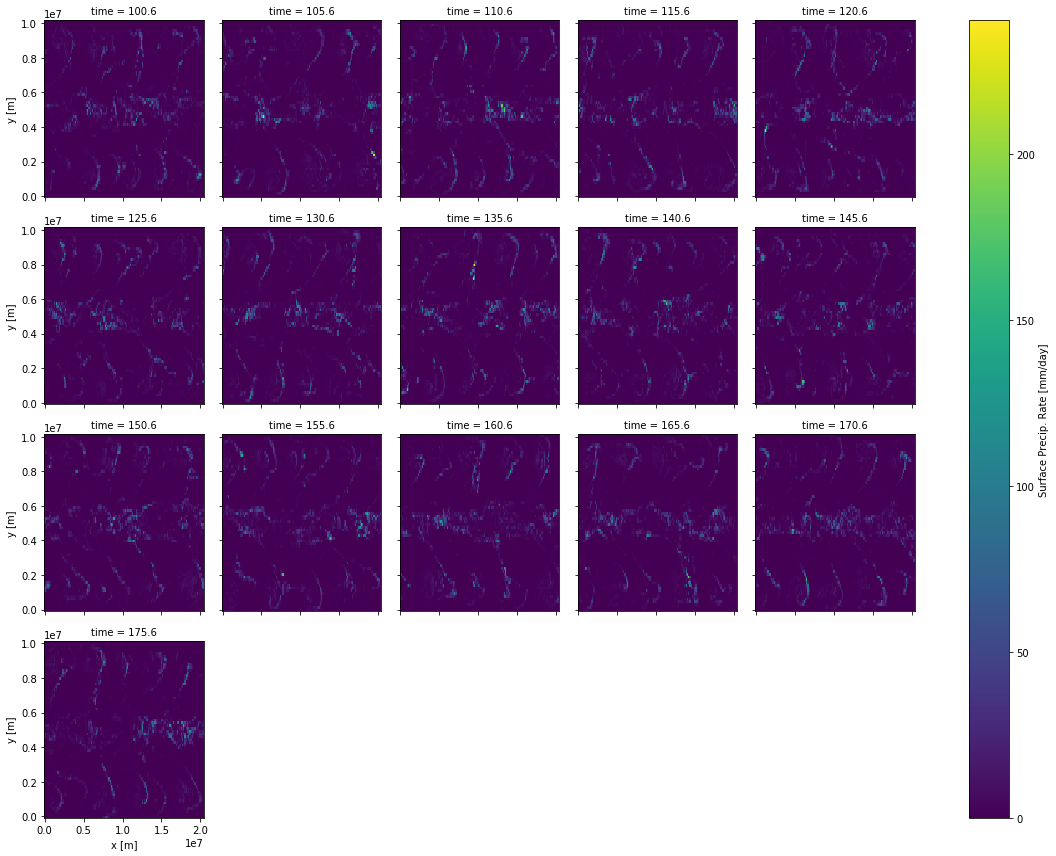

In [5]:
precip.plot(col='time', col_wrap=5)

Let's plot the "precipitable water", which is the total amount of water in the atmosphere above a given horizontal location.

$PW = \frac{1}{\rho_w} \int q_v \rho dz $

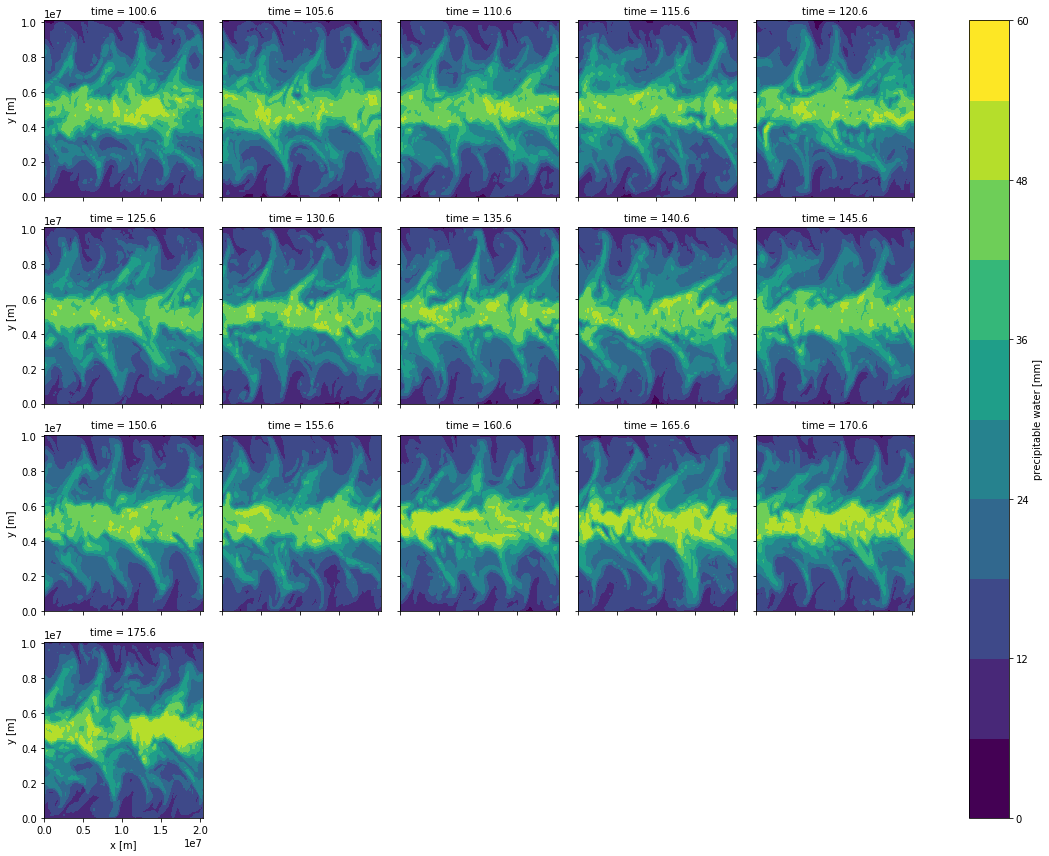

In [6]:
density_liquid_water = 1000
PW = (ds.QV * ds.layer_mass).sum('z')/density_liquid_water

# set up some meta data
PW.name = 'PW'
PW.attrs.update({'units': 'mm', 'long_name': 'precipitable water'})


PW.plot.contourf(col='time', col_wrap=5, levels=11)

## Using Holoviews to explore the Data

[Holoviews](http://holoviews.org/) is a really amazing tool for exploring these kinds of multi-dimensional datasets in a jupyter notebook. It works very well with xarray objects.

### Plotting a single snapshot with holoviews

I can plot the humidity at one time at the bottom of the atmosphere.

In [7]:
qv_snapshot = ds.QV.isel(time=0, z=0)
qv_snapshot

<xarray.DataArray 'QV' (y: 64, x: 128)>
array([[4.344667, 4.293538, 4.210835, ..., 4.221055, 4.282764, 4.299662],
       [4.583565, 4.561241, 4.500185, ..., 4.589958, 4.545974, 4.663091],
       [5.550419, 5.361629, 5.240573, ..., 5.448583, 5.525249, 5.662894],
       ...,
       [4.153488, 4.249261, 4.325951, ..., 4.203119, 4.363513, 4.234445],
       [4.183179, 4.210767, 4.189161, ..., 4.02697 , 4.066149, 4.196225],
       [4.197748, 4.213657, 4.239859, ..., 4.086829, 4.136678, 4.169605]],
      dtype=float32)
Coordinates:
    time     float64 100.6
  * x        (x) float32 0.0 160000.0 320000.0 480000.0 640000.0 800000.0 ...
  * y        (y) float32 0.0 160000.0 320000.0 480000.0 640000.0 800000.0 ...
    z        float32 37.0
Attributes:
    long_name:     Water Vapor                                               ...
    units:         g/kg      
    cell_methods:  step: mean

In [8]:
im = hv.Image(qv_snapshot)

This is an `hv.Image` object

In [9]:
print(im)

:Image   [x,y]   (QV)


It needs to be the last item in a cell to be visualized.

In [10]:
im

:Image   [x,y]   (QV)

This can be styled so it looks a little better:

In [11]:
%%opts Image[width=400, height=200, colorbar=True](cmap='viridis')
im

:Image   [x,y]   (QV)

### Interactive Exploration

Or I can plot it for several times. using the `hv.Dataset` object, and the various `.to` methods

In [12]:
%%opts Image[width=400, height=300, colorbar=True](cmap='viridis')

dmap = hv.Dataset(ds.QV).to.image(["x", "y"], dynamic=True)

What kind of object is `dmap`?

In [13]:
print(dmap)

:DynamicMap   [time,z]


It is a dynamic map, which means that it needs an active jupyter notebook to run, but it also doesn't save MBs of data inside the output cells of this file! If we used `dynamic=False` (the default), this would be a `hv.HoloMap` object, which would actuall save the data for each frame into this notebook file, which would result in a massive notebook.

**Aside: Why might we want a non-dynamic object?**

We can make a grid in height and time easily. The plot would be massive if we did that though, so lets' just plot for every fifth time and height.

### Compositing data into Grids

In [14]:
%%opts Image[width=200, height=100, colorbar=True](cmap='viridis') {+axiswise}


qt_subset = ds.QT[::5,::5]
hv.Dataset(qt_subset).to.image(["x", "y"]).grid(["time", "height"])

:GridSpace   [time,z]
   :Image   [x,y]   (QT)

### Vertical structure of humidity and temperature

Now let's look at the vertical "profiles" of humidity and temperature

In [15]:
%%opts Curve[invert_axes=True] {+framewise}
tabs = hv.Dataset(ds.TABS).to.curve("z", dynamic=True)
tabs

:DynamicMap   [time,x,y]
   :Curve   [z]   (TABS)

In [16]:
%opts Curve[invert_axes=True]

qv = hv.Dataset(ds.QV).to.curve("z", dynamic=True)

# need to explicitly set the x limits when using 'dynamic=True'
qv.redim.range(QV=(0, 20))

:DynamicMap   [time,x,y]
   :Curve   [z]   (QV)

In [17]:
# to subset a Dynamic Map use the redim.values method.

subset_qv_dmap = qv.redim.values(z=ds.z[::5])
subset_qv_dmap

:DynamicMap   [time,x,y]
   :Curve   [z]   (QV)

Now let's plot all of the y locations as line on this plot.

This is actually a bug. this error should only show up for non-dynamic maps. See this [github issue](https://github.com/ioam/holoviews/issues/3008). to get around it, we can specify an output

In [18]:
%%output max_frames=10000


qv_subset = ds.QV[::5,:,::10]
qv_dmap = hv.Dataset(qv_subset).to.curve("z", dynamic=True).overlay("y")
qv_dmap

:DynamicMap   [time,x]
   :NdOverlay   [y]
      :Curve   [z]   (QV)

I am colorblind though, so I cannot tell all these lines apart. However, they are increasing in "y" so it makes sense to use a sequential colormap.

Now we wrap these RGBA values in a `hv.Cycle` object and use it an `%%opts` magic

In [19]:
qv_dmap.options({'Curve': dict(color=hv.Cycle('Blues'))})

:DynamicMap   [time,x]
   :NdOverlay   [y]
      :Curve   [z]   (QV)


# Simple Machine Learning problem.



**Learning Objectives:**
1. How to preprocess xarray data into a format used by [scikit-learn](http://scikit-learn.org/stable/)
2. Demonstrate use of scikit learn regressor objects such as `LinearRegressor`.
3. Visualize performance of the trained models
4. Demonstrate scikit learn pipeline objects.

Let's predict the precipitation given the local profiles of humidity and temperature. This model would look like

        P ~ f(q_1, q_2,...q_nz, T_1, T_2,...,T_nz)
        
Where `f` is some machine learning model (e.g neural network, decision tree, etc). This assumes that the preicpitation in a given location is a function of the temperature and humidity at all levels above it.

A really good default method for doing this would be a method known as Gradient Boosting. It essentially averages the results of many decision trees in a special way.     

## Data munging

We will use [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html#sklearn.ensemble.GradientBoostingRegressor) to fit our model. But it requires data in a two-dimensional format, where the rows are "features" (e.g. predictors) and the columns are samples.

**Aside: How many samples do we have? How many features?**

Therefore, to make our code work, we need to

1. reshape our 4D xarray objects into 2D arrays
2. convert the data into numpy arrays
2. stack the variables along the height direction

### Reshaping the data

We can reshape the data using xarrays `stack` command. Features will be taken along the 'z' direction, and samples along the horizontal dimensions and time.

In [20]:
ds.QT

<xarray.DataArray 'QT' (time: 16, z: 34, y: 64, x: 128)>
[4456448 values with dtype=float32]
Coordinates:
  * time     (time) float64 100.6 105.6 110.6 115.6 120.6 125.6 130.6 135.6 ...
  * x        (x) float32 0.0 160000.0 320000.0 480000.0 640000.0 800000.0 ...
  * y        (y) float32 0.0 160000.0 320000.0 480000.0 640000.0 800000.0 ...
  * z        (z) float32 37.0 112.0 194.0 288.0 395.0 520.0 667.0 843.0 ...
Attributes:
    long_name:     Total non-precipitating water                             ...
    units:         g/kg      
    cell_methods:  step: mean

In [21]:
stacked_da = ds.QV.stack(samples=['x', 'y', 'time'], features=['z'])
stacked_da

<xarray.DataArray 'QV' (samples: 131072, features: 34)>
array([[4.344667, 4.088483, 3.987405, ..., 0.      , 0.      , 0.      ],
       [4.837313, 4.667844, 4.526313, ..., 0.      , 0.      , 0.      ],
       [3.963653, 3.823477, 3.724186, ..., 0.      , 0.      , 0.      ],
       ...,
       [4.166681, 4.10594 , 4.084893, ..., 0.      , 0.      , 0.      ],
       [4.085935, 4.099107, 4.067327, ..., 0.      , 0.      , 0.      ],
       [4.059505, 3.986066, 3.954415, ..., 0.      , 0.      , 0.      ]],
      dtype=float32)
Coordinates:
  * samples   (samples) MultiIndex
  - x         (samples) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  - y         (samples) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
  - time      (samples) float64 100.6 105.6 110.6 115.6 120.6 125.6 130.6 ...
  * features  (features) MultiIndex
  - z         (features) float64 37.0 112.0 194.0 288.0 395.0 520.0 667.0 ...
Attributes:
    long_name:     Water Vapor                        

To access the underlying numpy data we use the `.values` attribute.

In [22]:
qv_numpy = stacked_da.values

It has the right shape!

In [23]:
qv_numpy.shape

(131072, 34)

Let's now write a function to do this for multiple input variables and concatenate them together. We need to take some special care with variables like 'Prec' which do not have a 'z' dimension.

In [24]:
def stack_dims_and_concat_feats(ds, variables, sample_dims=('x', 'y', 'time'), feature_dims=('z')):
    """Convert certain variables of a data frame into 2D numpy arrays"""
    
    # convert tuple args to lists
    sample_dims = list(sample_dims)
    feature_dims = list(feature_dims)
    
    flat_arrays = []
    for name in variables:
        da = ds[name]
        # for two-d variables insert a singleton "z" dimension
        if 'z' not in da.dims:
            da = da.expand_dims('z')
        stacked_da = da.stack(samples=sample_dims, features=feature_dims)
        # make sure the rows are samples and columns are features
        tranposed_da = stacked_da.transpose('samples', 'features')
        flat_arrays.append(tranposed_da.values)

    # concatenate along the final dimension
    # also outuput coord info for later use

    return np.concatenate(flat_arrays, axis=1), stacked_da.samples

In [25]:
input_variables = ['QV', 'TABS']
output_variables = ['Prec']

# divide the domain into testing/training regions
ds_train = ds.isel(x=slice(0, 64))
ds_test = ds.isel(x=slice(64, None))

# get the input training data
(x_train, y_train), (x_test, y_test) = [[stack_dims_and_concat_feats(ds, variables)[0]
                                         for variables in [input_variables, output_variables]]
                                        for ds in [ds_train, ds_test]]

Here are the shapes, just to make sure my overly complicated list comprehension worked!

In [26]:
x_train.shape, y_train.shape

((65536, 68), (65536, 1))

## Training a machine learning model





**What is the simplest ML methods?**

In [27]:
from sklearn.linear_model import LinearRegression

Here is the documentation:

In [28]:
LinearRegression?

Init signature: LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
Docstring:     
Ordinary least squares Linear Regression.

Parameters
----------
fit_intercept : boolean, optional, default True
    whether to calculate the intercept for this model. If set
    to False, no intercept will be used in calculations
    (e.g. data is expected to be already centered).

normalize : boolean, optional, default False
    This parameter is ignored when ``fit_intercept`` is set to False.
    If True, the regressors X will be normalized before regression by
    subtracting the mean and dividing by the l2-norm.
    If you wish to standardize, please use
    :class:`sklearn.preprocessing.StandardScaler` before calling ``fit`` on
    an estimator with ``normalize=False``.

copy_X : boolean, optional, default True
    If True, X will be copied; else, it may be overwritten.

n_jobs : int, optional, default 1
    The number of jobs to use for the computation.
    If -1 all CPUs

We don't need any of these fancy options now, let's just use the defaults. We need to instantiate this object

In [29]:
lm = LinearRegression()

And the training it is very easy!

In [30]:
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Here are the attributes of this object:

In [31]:
[attr  for attr in dir(lm) if not attr.startswith('_')]

['coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_jobs',
 'normalize',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

What are the predicted precip values?

In [32]:
pred = lm.predict(x_train)

How is the R2 score:

In [33]:
from sklearn.metrics import r2_score


r2_score(y_train, pred)

0.2823164762853063

So we got an R2 of .28. We can wrap this into one step

In [34]:
lm.score(x_train, y_train)

0.2823164762853063

Let's scatter plot the two to see what is going on.

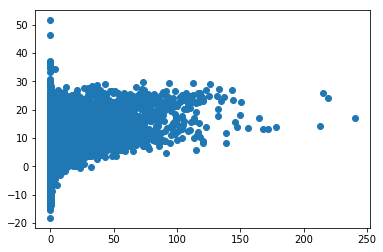

In [35]:
plt.scatter(y_train.ravel(), pred.ravel())

We have too much data! So we cannot see the distribution well. This is called "over-plotting"

### Resolving over-plotting

#### Turn down transparency

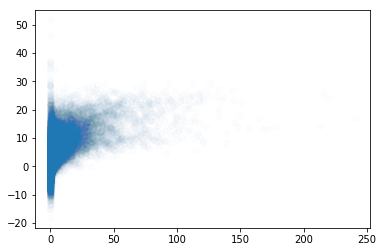

In [36]:
plt.scatter(y_train, pred, alpha=.01)

#### Use Hexbin

(0, 50)

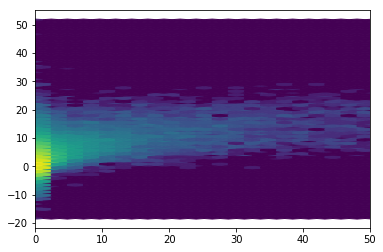

In [37]:
plt.hexbin(y_train, pred, bins='log')
plt.xlim([0,50])

This is kind of ugly IMO

### Datashader + holoviews

In [38]:
from holoviews.operation import decimate
from holoviews.operation.datashader import datashade

In [39]:
pts = hv.Points((y_train.ravel(), pred.ravel()))
decimate(pts, max_samples=1000).redim.range(x=(0,10))

:DynamicMap   []
   :Points   [x,y]

In [40]:
datashade(pts)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

In either case, we can clearly see that linear regression under-predicts precip.

## Visualizing the predicted precip

To visualize the precip, we need to move the predictions back to xarray land, that is why we output the sample_dim info in the original data

In [41]:
def predict_precip(lm, ds, input_variables=['QV', 'TABS']):
    """Predict precip with a given sklearn model"""
    x, sample_dim_info = stack_dims_and_concat_feats(ds, input_variables)
    precip = lm.predict(x)
    precip = precip.squeeze()
    precip_da = xr.DataArray(precip, dims=['samples'], coords={'samples': sample_dim_info})
    return precip_da.unstack('samples')

In [42]:
precip_pred = predict_precip(lm, ds)

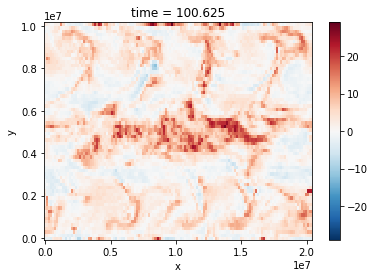

In [43]:
precip_pred.isel(time=0).plot(x='x')

We see the precip is much too smooth and does not have enough extreme values. Also, Prec<0 sometimes. **Have any of you ever experienced that?**

## Aside: better machine learning models

Let's wrap up the whole analysis into one script and try out some different models

In [44]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


def fit_predict_and_plot(model, ds):
    """Wrap up the whole analysis in one function"""
    
    input_variables = ['QV', 'TABS']
    output_variables = ['Prec']

    # divide the domain into testing/training regions
    ds_train = ds.isel(x=slice(0, 64))
    ds_test = ds.isel(x=slice(64, None))

    # get the input training data
    (x_train, y_train), (x_test, y_test) = [[stack_dims_and_concat_feats(ds, variables)[0]
                                             for variables in [input_variables, output_variables]]
                                            for ds in [ds_train, ds_test]]
    
    y_train = y_train.ravel()
    y_test = y_test.ravel()
    
    # fit the model
    model.fit(x_train, y_train)
    
    # Print the scores
    print("Model type:")
    print("-----------")
    print(model)
    print()
    print("Cross validation score:", model.score(x_test, y_test))
    print("Training score:", model.score(x_train, y_train))
    
    # plot the precip pattern
    first_step = ds.isel(time=slice(0,1))
    precip = predict_precip(model, first_step)
    xr.Dataset({'Pred': precip, 'Truth': first_step.Prec})\
      .to_array()\
      .plot(col='variable', x='x', col_wrap=1, vmin=-10, vmax=60, cmap='viridis')

/Users/noah/anaconda/envs/uwnet/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Here are the results again for a linear regression model:

Model type:
-----------
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Cross validation score: 0.2984764868267423
Training score: 0.2823164762853063


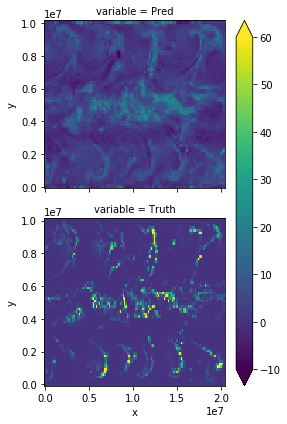

In [45]:
fit_predict_and_plot(LinearRegression(), ds)

Here is for a much fancier decision-tree based method called GradientBoosting.

      Iter       Train Loss   Remaining Time 
         1          81.3485           36.40s
         2          77.1923           34.63s
         3          73.5634           32.53s
         4          70.3307           31.59s
         5          67.5890           30.53s
         6          65.1909           29.75s
         7          63.1928           29.43s
         8          61.2917           28.88s
         9          59.8057           28.13s
        10          58.6350           27.34s
        20          50.2846           23.60s
        30          45.7827           20.00s
        40          43.6028           16.90s
        50          42.1098           13.92s
        60          40.9811           11.19s
        70          39.3998            8.30s
        80          38.2499            5.54s
        90          37.3224            2.76s
       100          36.5485            0.00s
Model type:
-----------
GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
 

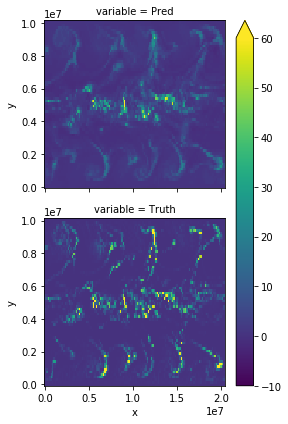

In [46]:
fit_predict_and_plot(GradientBoostingRegressor(verbose=True), ds)

We can see that this model is much better at predicting precip.

And here is a ....**neural network** model!

![](https://pbs.twimg.com/media/DqiaGC3WoAAJ7AV.jpg:large)

We will fit a neural network with 3 layers...maybe we should stack more.

Model type:
-----------
MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(32, 32, 32), learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

Cross validation score: 0.18221165505869252
Training score: 0.17651668419804878


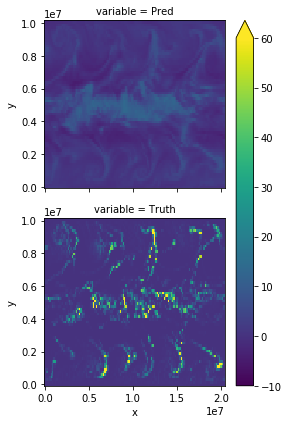

In [47]:
def get_nn_model():
    return MLPRegressor(max_iter=20, hidden_layer_sizes=(32,32,32), random_state=10,
                        early_stopping=True)

model = get_nn_model()
fit_predict_and_plot(model, ds)

Wait...I thought NNs were supposed to be good, but this model did even worse than the Linear regression.

**Any ideas why?**

### Scaling the input data

Here are the mean and standard deviation of the features.

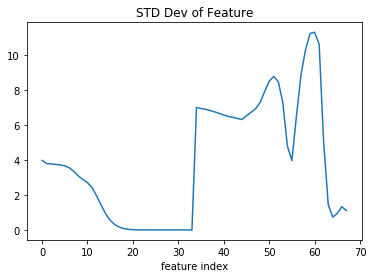

In [48]:
plt.plot(x_train.std(axis=0))
plt.xlabel('feature index')
plt.title("STD Dev of Feature");

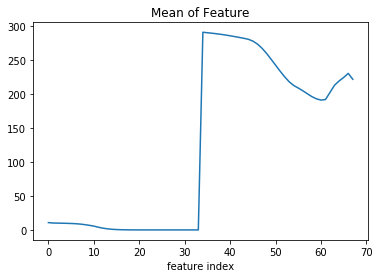

In [49]:
plt.plot(x_train.mean(axis=0))
plt.xlabel('feature index')
plt.title("Mean of Feature");

Some methods such as neural networks and decision trees do not care about the normalization of their inputs. But neural networks do! For this reason, scikit-learn provides a series of Transformer objects that can help with data-preprocesssing tasks such as normalization. These objects are used like this:

```
obj.fit(x_train)
xformed_data = obj.transform(x_train)
```

The one for de-meaning and scaling is called `StandardScaler`. Here is how you use it:

In [50]:
from sklearn.preprocessing import StandardScaler

In [51]:
scaler = StandardScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)

These two steps can be done in one go:

In [52]:
scaler.fit_transform(x_train);

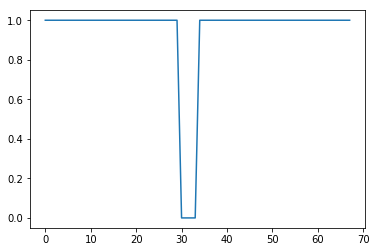

In [53]:
plt.plot(x_train_norm.std(axis=0))

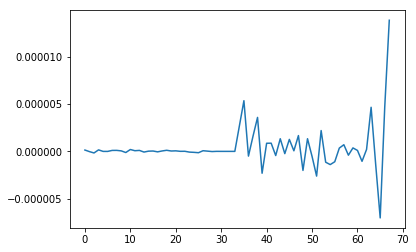

In [54]:
plt.plot(x_train_norm.mean(axis=0))

this is very close to zero also!

###  Scikit-learn pipelines

But how do we use `StandardScaler` with our previously defined `fit_predict_and_plot` function, which takes a `model` object? We do this using scikit-learn pipelines, these allow passing the data through a series of transformers before the final regression model. If you have two transformation objects followed by a model like this:

    transform1, transform2, regression_model
    
then sklearn pipelines, will allow you to take this code:
```
x1 = transform.fit_transform(x)
x2 = transform.fit_transform(x1)
regression_model.fit(x2, y)
```
and call it like this
```
model = make_pipeline(transform1, transform2, regression_model)
model.fit(x, y)
```
The advantage of this, is that from the perspective of `fit_predict_and_plot`, `model` is the same as any other model. In the following cell, I make a pipeline object we can use to train a neural network with scaled inputs!

Model type:
-----------
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('mlpregressor', MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=(32, 32, 32), learning_rate='constant'...       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False))])

Cross validation score: 0.5193756529216066
Training score: 0.6078361336047693


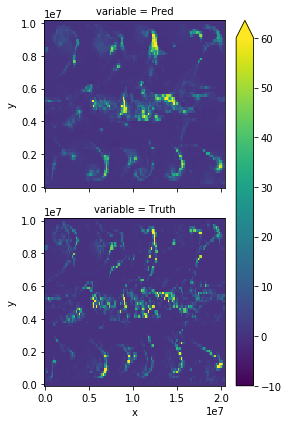

In [55]:
from sklearn.pipeline import make_pipeline

# this pipeline object first scales the input data and then predicts the output
normalized_mlp_regressor = make_pipeline(StandardScaler(), get_nn_model())
fit_predict_and_plot(normalized_mlp_regressor, ds)

The results are *much* better.